# Machine Learning Techniques - MISIS4219

## Taller 6

Este taller consta de un punto, el cual se desarrollara implementando todo lo que hemos visto en esta y las anteriores clases.

**Integrante 1:** Jose Manuel Moreno - 201011998

**Integrante 2:** William Ravelo - 201532093

**NOTA:**  El archivo .pynb entregado debe tener todas las celdas ejecutadas, con los resultados visibles. El nombre del archivo debe ser NombreCompleto_Taller6.ipynb

In [48]:
!pip install -q yfinance
!pip install pandas_datareader

## Objetivo: Predecir los próximos valores de cierre de stocks de compañías, dado el registro histórico de estas

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Para leer los datos de Yahoo
from pandas_datareader.data import DataReader
import yfinance as yf

# para settear tiempos
from datetime import datetime

from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Dataset: Para este problema usaremos la librería yfinance, la cual retorna los valores de stock para diferentes empresas, en este caso tenemos los valores de APPLE - AAPL, GOOGLE - GOOG, Microsoft _ MSFT, Amazon - AMZN

Como ejemplo solamente usamos los registros de 1 año, para el taller cambiar el codigo para ver los registros de los ultimos **3 años**

In [50]:
tech_list = ['AAPL', 'GOOG', 'MSFT', 'AMZN']

#Asignamos el rango de fechas en las que queremos consultar los datos
end = datetime.now() #fecha actual
start = datetime(end.year - 3, end.month, end.day) #Fecha de hace un año

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [51]:
company_list = [AAPL, GOOG, MSFT, AMZN]
company_name = ["APPLE", "GOOGLE", "MICROSOFT", "AMAZON"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name

df = pd.concat(company_list, axis=0)
df.tail(10)

,Open,High,Low,Close,Adj Close,Volume,company_name
Date,,,,,,,
2024-04-08,186.899994,187.289993,184.809998,185.190002,185.190002,39221300,AMAZON
2024-04-09,187.240005,187.339996,184.199997,185.669998,185.669998,36546900,AMAZON
2024-04-10,182.770004,186.270004,182.669998,185.949997,185.949997,35879200,AMAZON
2024-04-11,186.740005,189.770004,185.509995,189.050003,189.050003,40020700,AMAZON
2024-04-12,187.720001,188.380005,185.080002,186.130005,186.130005,38554300,AMAZON
2024-04-15,187.429993,188.690002,183.000000,183.619995,183.619995,48052400,AMAZON
2024-04-16,183.270004,184.830002,182.259995,183.320007,183.320007,32891300,AMAZON
2024-04-17,184.309998,184.570007,179.820007,181.279999,181.279999,31359700,AMAZON
2024-04-18,181.470001,182.389999,178.649994,179.220001,179.220001,30723800,AMAZON


# Seleccionar los datos de una de las compañías previamente ejecutadas y obtener los valores de stock de cierre (Close o Adj close)

In [52]:
df_apple = df[df['company_name'] == 'APPLE']
df_apple = df_apple.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"], axis=1)
df_apple.tail(10)

,Close,company_name
Date,,
2024-04-08,168.449997,APPLE
2024-04-09,169.669998,APPLE
2024-04-10,167.779999,APPLE
2024-04-11,175.039993,APPLE
2024-04-12,176.550003,APPLE
2024-04-15,172.690002,APPLE
2024-04-16,169.380005,APPLE
2024-04-17,168.000000,APPLE
2024-04-18,167.039993,APPLE


## Graficar la variación de los precios de salida a lo largo del tiempo seleccionado

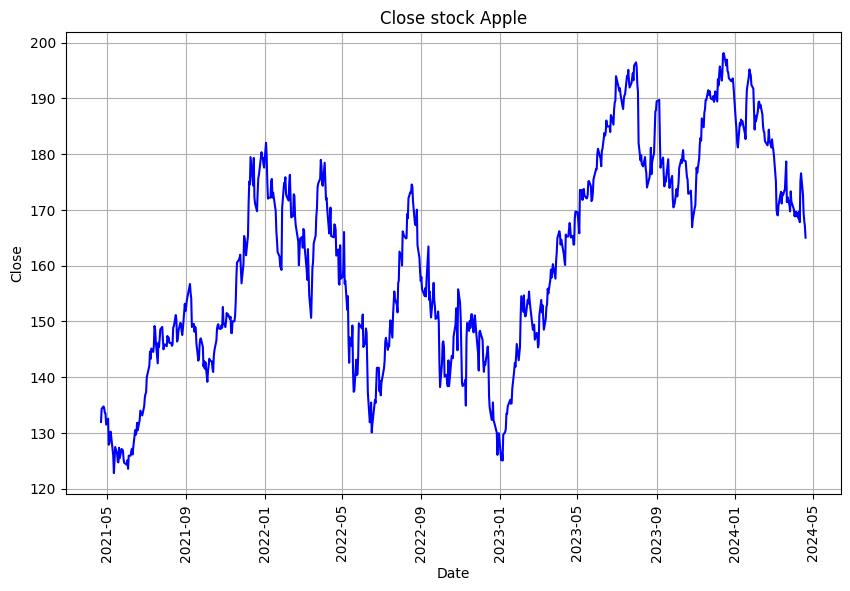

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(df_apple.index, df_apple['Close'], color='blue', linestyle='-')
plt.title('Close stock Apple')
plt.xlabel('Date')
plt.ylabel('Close')
plt.grid(True)
plt.xticks(rotation='vertical')

plt.show()

## Tomar el 60% de los datos para entrenar 20% para validación y 20% para test

In [54]:
# Se segmenta la data a evaluar, en los grupos de entrenamiento 
raw_data = df_apple['Close'].values #nota: usar .values para convertirlo en un array de numpy
num_train_samples = int(0.6 * len(raw_data)) #60% de los datos
num_val_samples = int(0.2 * len(raw_data)) #20% de los datos
num_test_samples = len(raw_data) - num_train_samples - num_val_samples #los datos restantes
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 452
num_val_samples: 150
num_test_samples: 152


In [55]:
# Estandarizacion de los datos. Primero restamos los valores por la media y luego se dividen por
# la desviación estandar
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

## Dividir los datos en X y Y.
Aquí realizamos en ejemplo con el entrenamiento. **Elaborar los datos para el test y validación**

In [56]:
# dividir los en x_train y y_train

train_start = 0
train_end = train_start + num_train_samples

val_start = train_end
val_end = val_start + num_val_samples

test_start = val_end
test_end = test_start + num_test_samples

train_data = raw_data[train_start:train_end]
valid_data = raw_data[val_start:val_end]
test_data = raw_data[test_start:test_end]

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

sequence_length = 60

for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i]) #obtenemos los datos de la secuencia 0-59
    y_train.append(train_data[i]) #el dato 60 se convierte en el target
    if i<= 61:
        print(x_train)
        print(y_train)

for i in range(sequence_length, len(valid_data)):
    x_val.append(valid_data[i-sequence_length:i]) #obtenemos los datos de la secuencia 0-59
    y_val.append(valid_data[i]) #el dato 60 se convierte en el target
    if i<= 61:
        print(x_val)
        print(y_val)

for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i]) #obtenemos los datos de la secuencia 0-59
    y_test.append(test_data[i]) #el dato 60 se convierte en el target
    if i<= 61:
        print(x_test)
        print(y_test)

# Convertimos x_train y y_train en arrays de numpy
x_train, y_train = np.array(x_train), np.array(y_train)
x_val, y_val = np.array(x_val), np.array(y_val)
x_test, y_test = np.array(x_test), np.array(y_test)

[array([-1.31039928, -1.14278159, -1.11461104, -1.13785223, -1.19489829,
       -1.20194147, -1.34420416, -1.26814345, -1.59844786, -1.58084046,
       -1.46533947, -1.43223848, -1.66887532, -1.73507677, -1.95621948,
       -1.80127875, -1.62661895, -1.70972337, -1.80973024, -1.82099835,
       -1.63647875, -1.76888218, -1.65126846, -1.66535373, -1.66887532,
       -1.77944641, -1.82663267, -1.84987386, -1.79494053, -1.90199003,
       -1.73648562, -1.73578119, -1.67662238, -1.64915572, -1.72099149,
       -1.63366159, -1.41322384, -1.47238265, -1.43646503, -1.32096404,
       -1.41463162, -1.28504535, -1.16672774, -1.18644734, -1.20687083,
       -1.22799928, -1.11038556, -1.00122279, -0.95685314, -0.9350208 ,
       -0.74557077, -0.60049038, -0.42090015, -0.5145688 , -0.38286979,
       -0.42583059, -0.34554333, -0.09834334, -0.1455296 , -0.29272273])]
[-0.5702070884531487]
[array([-1.31039928, -1.14278159, -1.11461104, -1.13785223, -1.19489829,
       -1.20194147, -1.34420416, -1.26

In [57]:
# se verifica la dimensión del conjunto de entrenamiento:
x_train.shape

(392, 60)

Para crear nuestro dataset de entrenamiento, prueba y validación usaremos la función 'timeseries_dataset_from_array'.

La idea general es que al proporcionar una matriz de datos de series temporales (el argumento de datos), timeseries_dataset_from_array
te da ventanas extraídas de la serie temporal original.

Por ejemplo, supongamos que nuestros datos son: [0 1 2 3 4 5 6] y sequence_length=3, entonces timeseries_dataset_from_array generará las siguientes muestras: [0 1 2], [2 3 4], [3 4 5], [4 5 6].

Usaremos la función timeseries_dataset_from_array para inicializar tres datasets: uno para entrenamiento, otro para prueba y otro para validación:


* sequence_length : Longitud de las secuencias de salida (en número de pasos de tiempo).


Documentación: https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array


In [58]:
# Se procede a utilizar TensorFlow y NumPy para crear conjuntos de datos de series temporales 
# para entrenar, validar y probar el modelo. 

import numpy as np
from tensorflow import keras

batch_size = 32

train_dataset = keras.utils.timeseries_dataset_from_array(
                    x_train,
                    targets=y_train,
                    sequence_length=sequence_length,
                    shuffle=True,
                    batch_size=batch_size)

val_dataset = keras.utils.timeseries_dataset_from_array(
                    x_val,
                    targets=y_val,
                    sequence_length=sequence_length,
                    shuffle=True,
                    batch_size=batch_size)

test_dataset = keras.utils.timeseries_dataset_from_array(
                    x_test,
                    targets=y_test,
                    sequence_length=sequence_length,
                    shuffle=True,
                    batch_size=batch_size)

In [59]:
# Ahora, se itera sobre el conjunto de datos de entrenamiento (train_dataset) y se extraen muestras y objetivos en cada iteración.
# Para cada iteración, samples contiene un lote de datos de entrada, mientras que target contiene los objetivos correspondientes 
# para esas muestras. La línea de impresión (print) dentro del bucle muestra la forma (shape) de las muestras y 
# los objetivos en cada iteración.
for samples, target in train_dataset:
  print(f'sample shape: {samples.shape}, target shape: {target.shape}')

sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (32, 60, 60), target shape: (32,)
sample shape: (13, 60, 60), target shape: (13,)


2024-04-22 15:58:18.019908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Crear Modelo

In [60]:
# Ahora se cambia la forma (reshape) de los conjuntos de datos de entrada (x_train, x_val, x_test) para adaptarlos 
# a la entrada requerida por el modelo. 

# La nueva forma (x.shape[0], x.shape[1], 1) indica que los datos se están reorganizando en una estructura tridimensional, 
# donde la primera dimensión (x.shape[0]) representa el número de muestras, la segunda (x.shape[1]) representa la 
# longitud de la secuencia temporal, y la tercera (1) representa una sola característica o variable en cada punto 
# de tiempo de la serie temporal.

x_train_reshaped = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val_reshaped = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape)

(392, 60)


In [61]:
# Se procede a construir un modelo con arquitectura secuencial, donde se tienen 2 tipos de capas:

# Capa LSTM (Long Short-Term Memory): Esta es la capa principal del modelo y se utiliza para capturar dependencias 
# de largo plazo en los datos de series temporales. La capa LSTM tiene 128 unidades de memoria (neuronas) y recibe 
# datos de entrada en un formato tridimensional. Aquí, sequence_length representa la longitud de la secuencia temporal 
# y x_train_reshaped.shape[2] representa el número de características en cada punto de tiempo de la serie temporal.

# Capa Densa (Fully Connected): Esta es la capa de salida del modelo y consta de una única neurona. 
# No tiene función de activación específica, lo que implica que se utiliza una función de activación lineal. 
# Esta capa se utiliza para generar la salida final del modelo, se predice un único número.

model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=(sequence_length, x_train_reshaped.shape[2])),
    keras.layers.Dense(1)
])

# Se compila el modelo:
model.compile(optimizer='adam', loss='mse')  # mse: Error cuadrático medio para regresión




/Users/josemorenoc/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
# se parametriza el ajuste del modelo:

epochs = 50
batch_size = 32
early = keras.callbacks.EarlyStopping(monitor='val_loss',patience=10)

model_history = model.fit(x_train_reshaped, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val_reshaped, y_val), callbacks=[early])

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - loss: 0.4777 - val_loss: 0.3518
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1574 - val_loss: 0.1914
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1228 - val_loss: 0.1803
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1033 - val_loss: 0.1392
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0912 - val_loss: 0.1348
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1074 - val_loss: 0.1649
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0897 - val_loss: 0.0909
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0908 - val_loss: 0.1461
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0852 - val_loss: 0.0730
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0901 - val_loss: 0.1089
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0774 - val_loss: 0.0795
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.

In [63]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,069 (781.52 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 133,380 (521.02 KB)

<Axes: xlabel='epochs', ylabel='loss'>

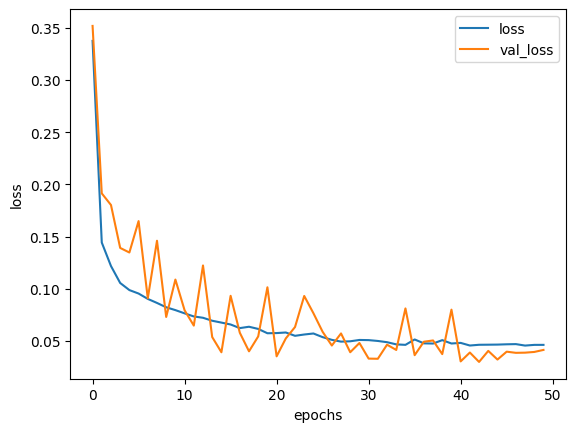

In [64]:
df_history = pd.DataFrame(model_history.history)
df_history.plot(y=['loss', 'val_loss'], xlabel='epochs', ylabel='loss')

In [65]:
# según los resultados del ajuste, se encuentra que el modelo tiene una tendencia a ajustarse de forma adecuada;
# es decir, que no se tiene evidencia de sobreajuste... y al contrario, se logra disminuir la función de pérdida de validación.


In [66]:
df_history.tail()

,loss,val_loss
45,0.046885,0.039818
46,0.047059,0.038702
47,0.045657,0.038874
48,0.046326,0.039553
49,0.046333,0.041499


# Evaluación del modelo

In [67]:
loss = model.evaluate(x_test_reshaped, y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0449


In [68]:
# Se realiza la evaluación del modelo entrenado sobre el conjunto de datos de prueba (x_test) y 
# se calculan las tres métricas más conocidas para evaluar rendimiento.

# en términos generales, se tiene una aceptablae bondad de ajuste del modelo R-cuadrado.

predictions = model.predict(x_test)

# Calcular MSE
mse = mean_squared_error(y_test, predictions)

# Calcular MAE
mae = mean_absolute_error(y_test, predictions)

# Calcular R^2
r2 = r2_score(y_test, predictions)

print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
MSE: 0.03929005568950791
MAE: 0.15786906436188983
R^2: 0.9133857786069735


## Calculo sobre datos de validacion: 

In [69]:
# Se realiza la evaluación del modelo entrenado sobre el conjunto de datos de validación (x_val) y 
# se calculan las tres métricas más conocidas para evaluar rendimiento.

# en términos generales, se tiene una aceptablae bondad de ajuste del modelo R-cuadrado.

predictions_val = model.predict(x_val)

# Calcular MSE
mse_val = mean_squared_error(y_val, predictions_val)

# Calcular MAE
mae_val = mean_absolute_error(y_val, predictions_val)

# Calcular R^2
r2_val = r2_score(y_val, predictions_val)

print(f'MSE: {mse_val}')
print(f'MAE: {mae_val}')
print(f'R^2: {r2_val}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
MSE: 0.04149906834053997
MAE: 0.1656063793120323
R^2: 0.8550876381450291


## Graficar resultados

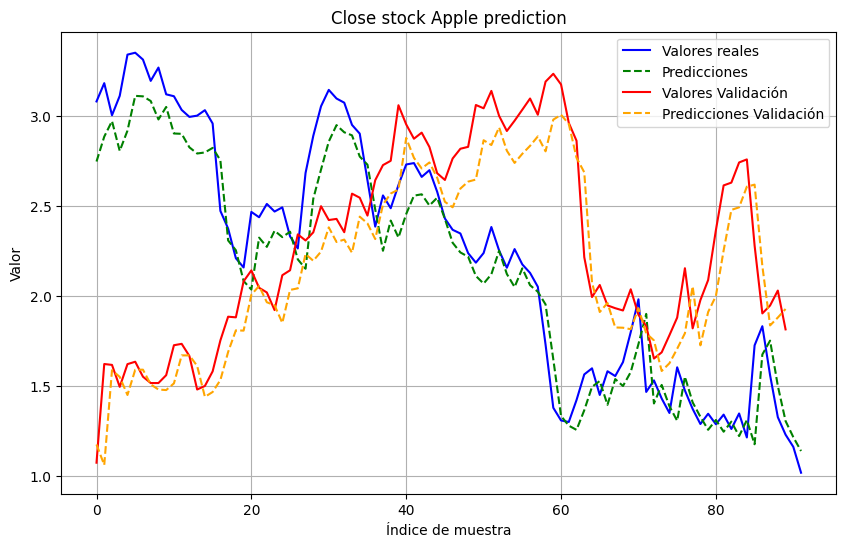

In [70]:
# Graficar las predicciones vs los valores reales, tanto para los valores de PRUEBA como para los de VALIDACIÓN:

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Valores reales', linestyle='-',color='blue')
plt.plot(predictions, label='Predicciones', linestyle='--',color='green')
plt.plot(y_val, label='Valores Validación', linestyle='-',color='red')
plt.plot(predictions_val, label='Predicciones Validación', linestyle='--',color='orange')
plt.title('Close stock Apple prediction')
plt.xlabel('Índice de muestra')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# a continuación se prepara la información para retomar las unidades e interpretación inicial, en 3 pasos:

# 1. Se convierten las matrices de predicciones (predictions) y valores verdaderos (y_test) en objetos 
# DataFrame de Pandas (df_test y df_prediction, respectivamente)
# 2. Como los datos de entrada fueron normalizados previamente antes de entrenar el modelo,
# estas líneas revierten ese proceso de normalización. Esto se hace multiplicando las predicciones 
# y los valores verdaderos por la desviación y sumando la media. Esto devuelve los datos a su escala original.
# 3. Se asignan los índices de fecha a los DataFrames df_test y df_prediction.


df_test = pd.DataFrame(y_test)
df_prediction = pd.DataFrame(predictions)

df_test = (df_test * std) + mean
df_prediction = (df_prediction * std) + mean

total_length = len(df_apple['Close'])
date_indexes = df_apple['Close'][total_length - len(df_prediction):].index

df_test.index = date_indexes
df_prediction.index = date_indexes

## Resultados finales:

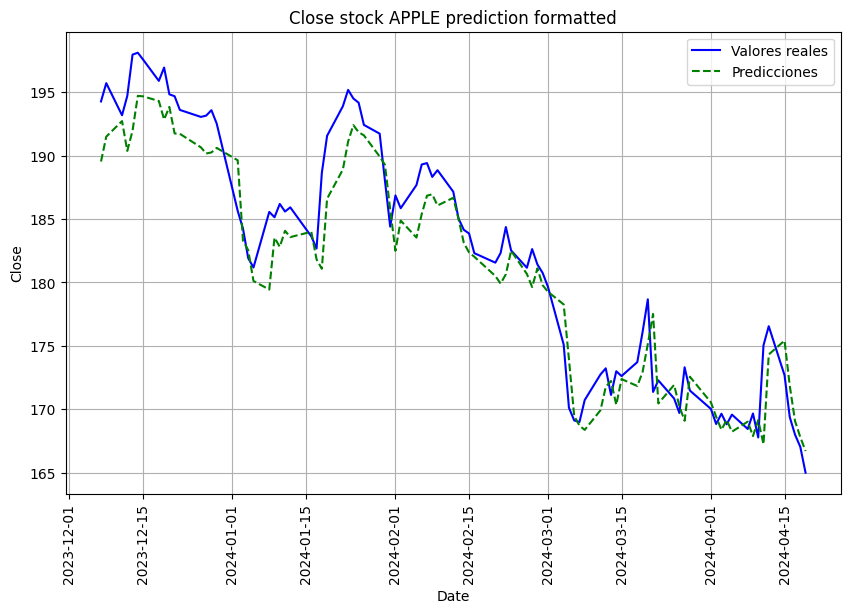

In [74]:
# Se presenta la información procesada de forma gráfica, según los resultados del modelo
# BAsado en los resultados de la función de pérdida en validación, según los resultados del R2 para los datos de validación,
# y la evidencia gráfica del modelo, puede concluirse que el ajuste logrado con el modelo de redes neuronales
# es acertado, oportuno, y se logra una caracterización de las condiciones generales de la serie de tiempo, 
# sin caer en sobreajuste u otros problemas de especificación del modelo.

plt.figure(figsize=(10, 6))
plt.plot(df_test.index, df_test[0], color='blue', linestyle='-', label='Valores reales')
plt.plot(df_prediction.index, df_prediction[0], color='green', linestyle='--', label='Predicciones')
plt.title('Close stock APPLE prediction formatted')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.xticks(rotation='vertical')
plt.show()

